# 2021-01-13 • Multiple ROC's

Here we repeat the simulation multiple times (each time varying one parameter), and for each repetition calculate an ROC curve (and associated area under that curve): how well could we classify all (spike_train, VI_signal)-pairs as connected or unconnected, for a range of p-value thresholds?

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Fri 15 Jan** 2021, at 22:11 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/ac93c3c585356364e13ba717361968cc6e4e7ff2
) (Fri 15 Jan 2021, 22:07).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/sim/izhikevich_neuron.py
```

In [3]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, sim_and_eval, plot_sim_slice

In [4]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [104]:
base_params = N_to_1_SimParams(
    sim_duration = 1 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 2,
    rng_seed=1800,
);

In [105]:
sim_data = simulate(base_params);

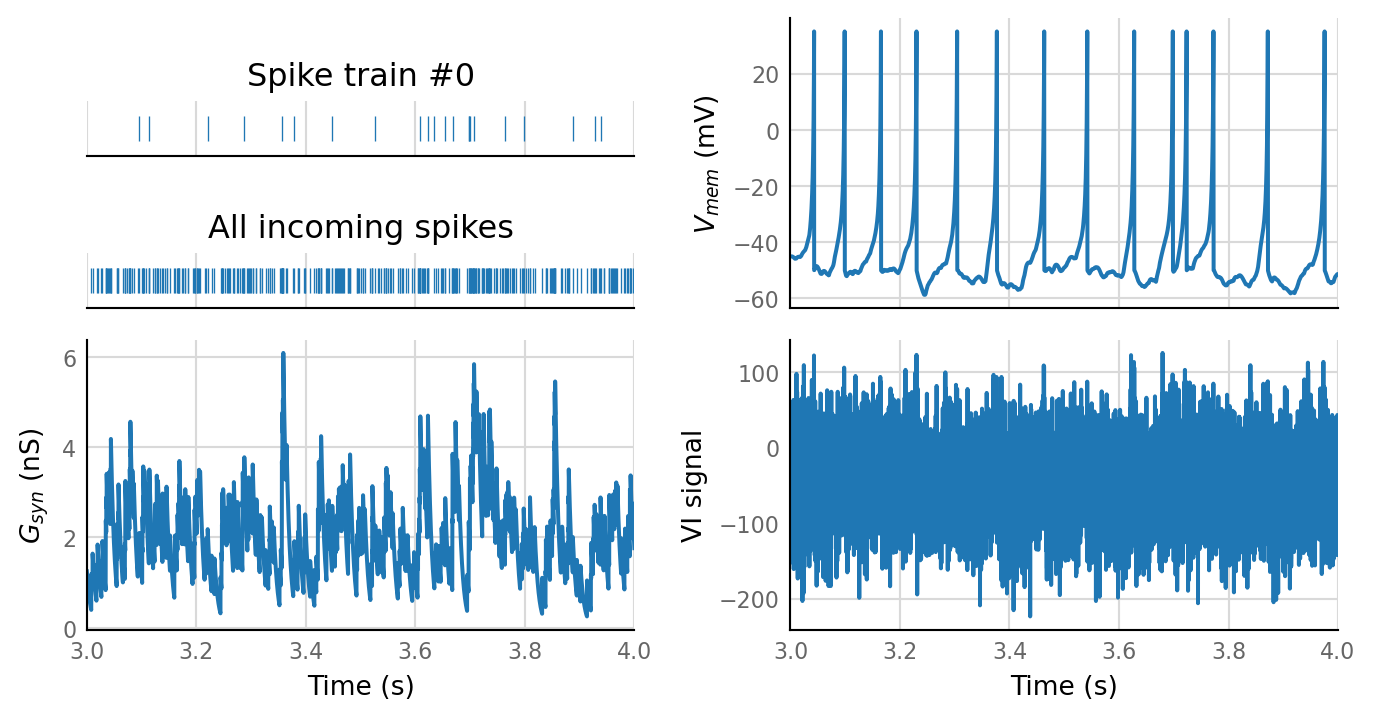

In [106]:
plot_sim_slice(sim_data, t_start=3 * second, duration=1 * second);

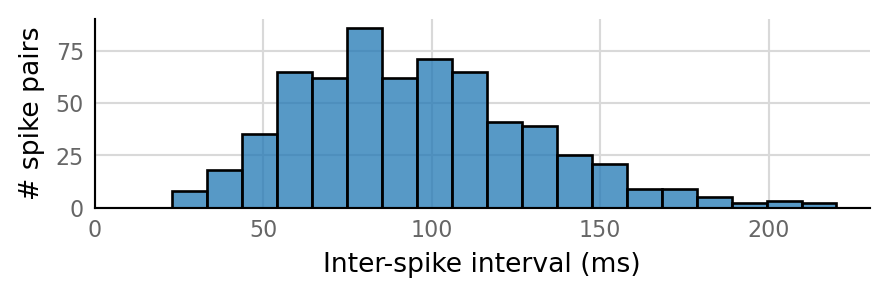

Output spike rate (1 / median ISI): 11 Hz


In [107]:
v.sim.izhikevich_neuron.show_output_spike_stats(sim_data.izh_output);

In [108]:
test_data, test_summaries = v.N_to_1_experiment.test_connections(sim_data);

Testing connections: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s]


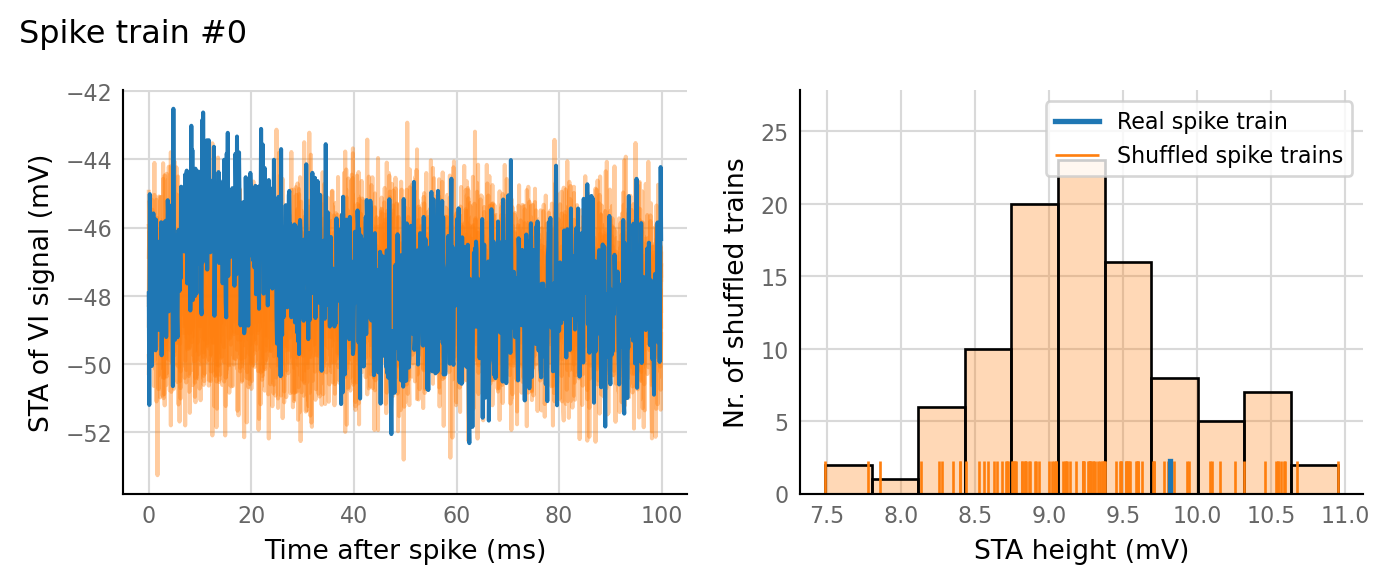

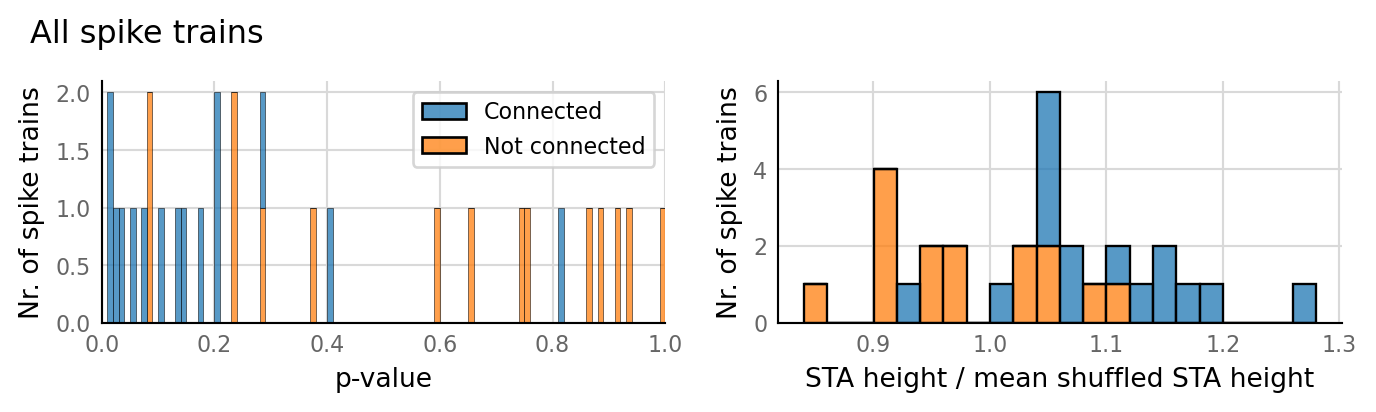

In [109]:
v.N_to_1_experiment.plot_conntest(test_data, test_summaries, sim_data)

In [110]:
classifs = v.conntest.classification.sweep_threshold(test_summaries, sim_data.is_connected);

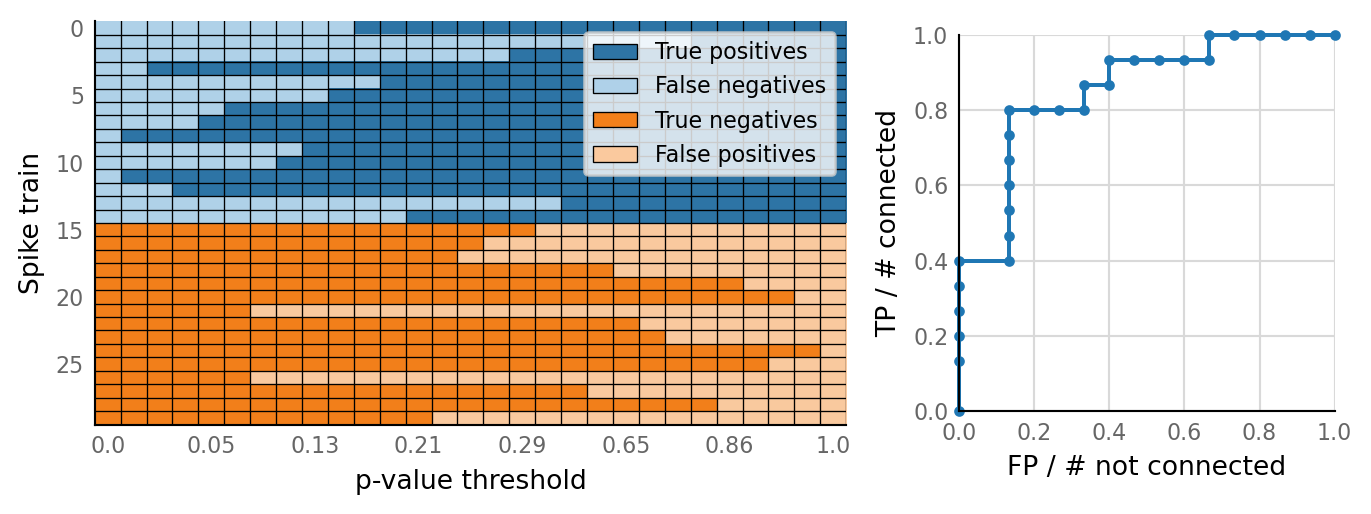

In [111]:
v.N_to_1_experiment.plot_classifications_with_ROC(classifs)

## Vary one parameter

In [112]:
from voltage_to_wiring_sim.N_to_1_experiment import simulate, test_connections
from voltage_to_wiring_sim.conntest.classification import sweep_threshold

def sim_and_eval(params):
    with v.time_op("Sim"):
        sim_data = simulate(params)
    test_data, test_summaries = test_connections(sim_data)
    classifs = sweep_threshold(test_summaries, sim_data.is_connected)
    return classifs

In [113]:
SNRs = [1, 2, 4, 8];

In [114]:
from copy import deepcopy

thr_sweeps = []

for SNR in SNRs:
    print(f"SNR: {SNR}")
    params = deepcopy(base_params)
    params.imaging_spike_SNR = SNR
    thr_sweep = sim_and_eval(params)
    thr_sweeps.append(thr_sweep)
    print()

SNR: 1
Sim: … (0.534 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 17.89it/s]

SNR: 2
Sim: … (0.866 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 20.13it/s]

SNR: 4
Sim: … (0.508 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 20.23it/s]

SNR: 8
Sim: … (0.545 s)
Testing connections: 100%|██████████| 30/30 [00:01<00:00, 18.61it/s]



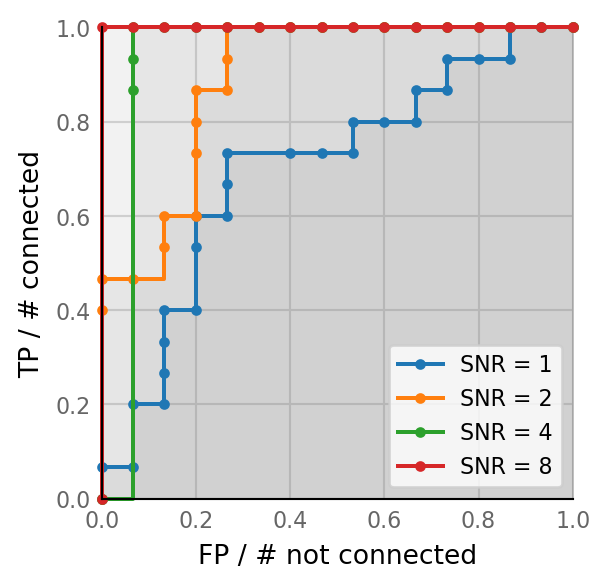

In [126]:
plot_ROC = v.conntest.classification.plot_ROC

ax = None
for i, (SNR, classifs) in enumerate(zip(SNRs, thr_sweeps)):
    ax = plot_ROC(classifs, ax,
                  label=f"SNR = {SNR}",
                  marker='.',
                  color=f"C{i}")
ax.legend();

In [131]:
def AUC(thr_sweep):
    TPRs = [tr.evaluation.TPR for tr in thr_sweep]
    FPRs = [tr.evaluation.FPR for tr in thr_sweep]
    AUC = 0
    # this is not the same as `np.trapz` e.g.
    for i in range(len(FPRs) - 1):
        AUC += (FPRs[i+1] - FPRs[i]) * TPRs[i]
    return AUC

In [137]:
df = pd.DataFrame(dict(SNR=SNRs, AUC=[AUC(s) for s in thr_sweeps]))

,SNR,AUC
0,1,0.702222
1,2,0.893333
2,4,0.933333
3,8,1.000000


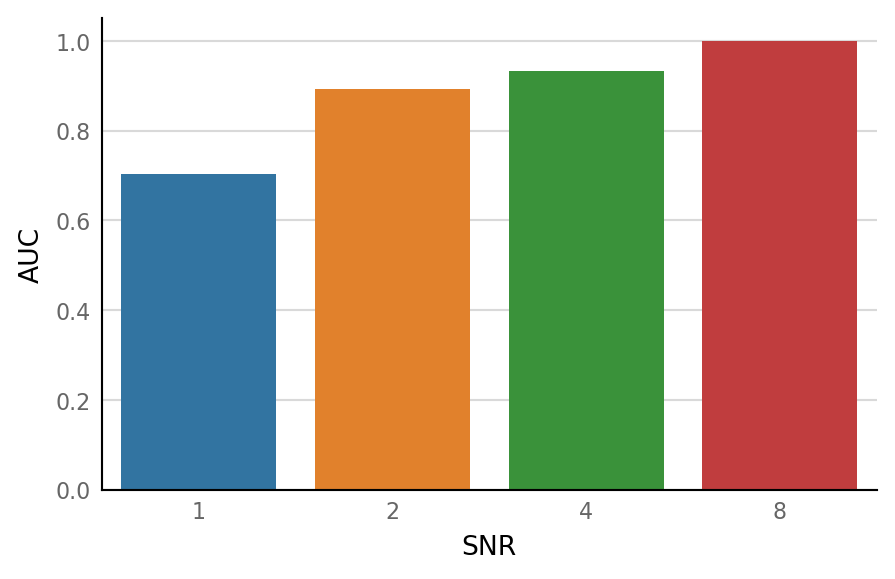

In [144]:
sns.barplot(data=df, x="SNR", y="AUC");

## Reproducibility

In [32]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Fri 15 Jan** 2021, at 22:33 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/d056b88f9d20ae39eb0a31cf170894702af7a935
) (Fri 15 Jan 2021, 22:28).

Uncommited changes to:
```
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
nptyping             1.4.0
tqdm                 4.56.0


In [31]:
!conda list

# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    3.2.1              pyh9f0ad1d_0    conda-forge
brotlipy                  0.7.0           py38h294d835_1001    conda-forge
bzip2                     1.0.8                h8ffe710_4    conda-forge
ca-certifi

reproc                    14.2.1               h8ffe710_0    conda-forge
reproc-cpp                14.2.1               h0e60522_0    conda-forge
requests                  2.25.1             pyhd3deb0d_0    conda-forge
requests-toolbelt         0.9.1                    pypi_0    pypi
rfc3986                   1.4.0                    pypi_0    pypi
ruamel_yaml               0.15.80         py38h294d835_1003    conda-forge
scikit-learn              0.24.0           py38ha09990b_0    conda-forge
scipy                     1.6.0            py38h5f893b4_0    conda-forge
seaborn                   0.11.1               h57928b3_0    conda-forge
seaborn-base              0.11.1             pyhd8ed1ab_0    conda-forge
send2trash                1.5.0                      py_0    conda-forge
setuptools                49.6.0           py38haa244fe_3    conda-forge
setuptools-scm            5.0.1                    pypi_0    pypi
six                       1.15.0             pyh9f0ad1d_0    conda-for